In [40]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import RandomizedSearchCV
import os
import pickle
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

In [41]:
df = pd.read_csv('Data/digital_marketing_campaign_dataset.csv')
df.head()

,CustomerID,Age,Gender,Income,CampaignChannel,CampaignType,AdSpend,ClickThroughRate,ConversionRate,WebsiteVisits,PagesPerVisit,TimeOnSite,SocialShares,EmailOpens,EmailClicks,PreviousPurchases,LoyaltyPoints,AdvertisingPlatform,AdvertisingTool,Conversion
0,8000,56,Female,136912,Social Media,Awareness,6497.870068,0.043919,0.088031,0,2.399017,7.396803,19,6,9,4,688,IsConfid,ToolConfid,1
1,8001,69,Male,41760,Email,Retention,3898.668606,0.155725,0.182725,42,2.917138,5.352549,5,2,7,2,3459,IsConfid,ToolConfid,1
2,8002,46,Female,88456,PPC,Awareness,1546.429596,0.277490,0.076423,2,8.223619,13.794901,0,11,2,8,2337,IsConfid,ToolConfid,1
3,8003,32,Female,44085,PPC,Conversion,539.525936,0.137611,0.088004,47,4.540939,14.688363,89,2,2,0,2463,IsConfid,ToolConfid,1
4,8004,60,Female,83964,PPC,Conversion,1678.043573,0.252851,0.109940,0,2.046847,13.993370,6,6,6,8,4345,IsConfid,ToolConfid,1


In [42]:
print("========== Missing Values ==========")
print(df.isnull().sum())

print("========== Duplicate Values ==========")
print(df.duplicated().sum())

========== Missing Values ==========
CustomerID             0
Age                    0
Gender                 0
Income                 0
CampaignChannel        0
CampaignType           0
AdSpend                0
ClickThroughRate       0
ConversionRate         0
WebsiteVisits          0
PagesPerVisit          0
TimeOnSite             0
SocialShares           0
EmailOpens             0
EmailClicks            0
PreviousPurchases      0
LoyaltyPoints          0
AdvertisingPlatform    0
AdvertisingTool        0
Conversion             0
dtype: int64
========== Duplicate Values ==========
0


In [43]:
print(df['CampaignChannel'].unique())
print(df['CampaignType'].unique())


['Social Media' 'Email' 'PPC' 'Referral' 'SEO']
['Awareness' 'Retention' 'Conversion' 'Consideration']


Data Cleaning

Our personalised marketing efforts in this case involves 
1. email and PPC for targeted ads
2. Social Media for brand awareness and customer engagement
3. Referral for acquiring customers through existing clients
4. SEO to improve search visibility and credibility

During our marketing campaign, we ran different campaign types to promote our product and services:
Awareness: When banks aim to introduce their services to potential customers, creating brand visibility.
Consideration: When potential customers start evaluating banking options, researching products and benefits.
Conversion: When customers are ready to act, applying for a product or opening an account.
Retention: When banks focus on keeping existing customers engaged and satisfied, fostering loyalty.

In [44]:
# dropping information redundant to our campaign which will help us calculate ROI
df.drop(
    columns=[
        'AdvertisingTool',
        'AdvertisingPlatform',
        'PagesPerVisit',
        'EmailOpens',
        'WebsiteVisits',
        'TimeOnSite',
        'SocialShares',
        'ClickThroughRate'],
    inplace=True
)

In [45]:
df.dtypes

CustomerID             int64
Age                    int64
Gender                object
Income                 int64
CampaignChannel       object
CampaignType          object
AdSpend              float64
ConversionRate       float64
EmailClicks            int64
PreviousPurchases      int64
LoyaltyPoints          int64
Conversion             int64
dtype: object

In this case we decided to keep the relevant stages of conversion and retention, which are relevant for measuring and maximizing ROI of our marketing efforts

Conversion: This stage directly impacts ROI because it focuses on customer actions, such as applying for a product or opening an account. It is the most immediate driver of revenue and is essential for calculating the effectiveness of marketing spend in acquiring new customers.

Retention: Retaining customers can improve lifetime value, which is a crucial factor for maximizing ROI. Engaged and loyal customers are more likely to make additional purchases, use more services, or even refer new customers, thereby enhancing long-term revenue.

In [46]:
df_marketing = df[df['CampaignType'].isin(['Conversion', 'Retention'])]
df_marketing

,CustomerID,Age,Gender,Income,CampaignChannel,CampaignType,AdSpend,ConversionRate,EmailClicks,PreviousPurchases,LoyaltyPoints,Conversion
1,8001,69,Male,41760,Email,Retention,3898.668606,0.182725,7,2,3459,1
3,8003,32,Female,44085,PPC,Conversion,539.525936,0.088004,2,0,2463,1
4,8004,60,Female,83964,PPC,Conversion,1678.043573,0.109940,6,8,4345,1
7,8007,56,Female,57083,Social Media,Conversion,5324.283667,0.188946,3,0,2983,1
8,8008,36,Female,140788,Email,Retention,9421.250951,0.112585,8,5,460,1
...,...,...,...,...,...,...,...,...,...,...,...,...
7989,15989,50,Female,84079,PPC,Retention,277.975579,0.183031,0,0,2935,0
7991,15991,62,Female,69289,SEO,Retention,6118.863881,0.047079,5,3,3075,1
7992,15992,37,Male,138422,Referral,Retention,2024.148848,0.068403,0,5,2733,0
7993,15993,20,Male,120271,Social Media,Retention,6973.120174,0.174582,1,7,3066,0


In [47]:
df_marketing.describe()

,CustomerID,Age,Income,AdSpend,ConversionRate,EmailClicks,PreviousPurchases,LoyaltyPoints,Conversion
count,4024.000000,4024.000000,4024.000000,4024.000000,4024.000000,4024.000000,4024.000000,4024.000000,4024.000000
mean,11984.893390,44.011680,84568.041750,4987.186666,0.104061,4.484841,4.530815,2480.162525,0.897117
std,2293.596494,14.822644,37395.411917,2846.222990,0.054973,2.856980,2.890158,1423.547374,0.303843
min,8001.000000,18.000000,20057.000000,103.956957,0.010020,0.000000,0.000000,1.000000,0.000000
25%,9985.750000,32.000000,51917.000000,2472.063139,0.056163,2.000000,2.000000,1257.500000,1.000000
50%,12000.000000,44.000000,84526.500000,5039.892169,0.103603,4.000000,5.000000,2471.500000,1.000000
75%,13934.000000,57.000000,116432.750000,7432.776248,0.150915,7.000000,7.000000,3676.000000,1.000000
max,15996.000000,69.000000,149986.000000,9997.914781,0.199995,9.000000,9.000000,4999.000000,1.000000


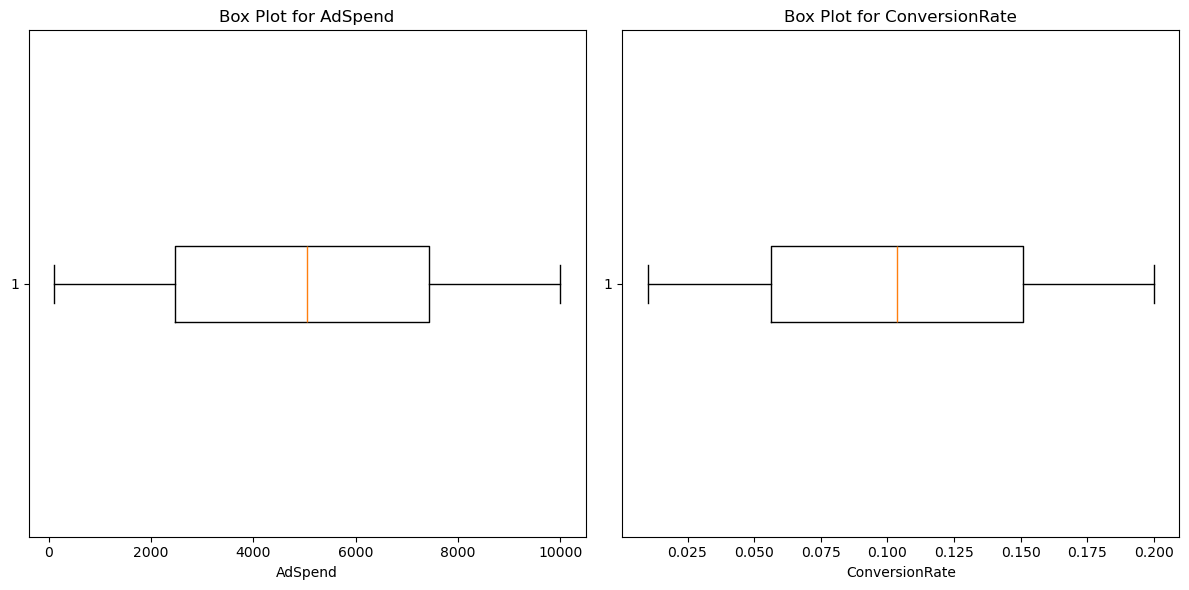

In [48]:
# Checking for outliers in the case of income, adspend and timeonesite
columns = ['AdSpend', 'ConversionRate']

# Set up the plot
plt.figure(figsize=(12, 6))

# Generate a box plot for each column
for i, column in enumerate(columns, 1):
    plt.subplot(1, len(columns), i)
    plt.boxplot(df_marketing[column].dropna(), vert=False)
    plt.title(f'Box Plot for {column}')
    plt.xlabel(column)

plt.tight_layout()
plt.show()


The box plots reveal that AdSpend, Income, and TimeOnSite have well-distributed values with no outliers. This will help to ensure that the analysis of ROI for personalized marketing efforts reflects typical customer behavior and avoids misleading extremes. This help ensure that our model will have more reliable predictions later on, without the need for outlier handling.

Feature Engineering step

Proceed to perform feature engineering to calculate
1. ROI
Our average revenue per conversion is taken from overall value earned from our banking clients particularly in areas like private banking, mortgages, corporate banking, and investment accounts, amoutning to 60,000.

Our ROI here is calculated: Total Revenue - Total Ad Spend / Total Ad Spend
Where totla revenue is the conversion rate of each customer * 60,000 (average revenue per conversion)

2. Customer Lifetime value
Total revenue a business can expect from a customer, adjusted by factors like loyalty points and conversion metrics.

CLV focuses on average revenue per conversion, multiplied by expected purchase frequency within a chosen period (e.g., a year). 

3. Conversion Rates
Recorded in the dataset

4. Campaign costs
Represented by Ad spend

In [49]:
avg_revenue_per_conversion = 60000

# Calculate estimated revenue from conversion rate and average revenue per conversion
df_marketing['Revenue'] = df_marketing['ConversionRate'] * avg_revenue_per_conversion
df_marketing['ROI'] = (df_marketing['Revenue'] - df_marketing['AdSpend']) / df_marketing['AdSpend'] 

# Calculate CLV, assuming a standard period of 1 year
df_marketing['CLV'] = (avg_revenue_per_conversion + df_marketing['LoyaltyPoints']) * df_marketing['PreviousPurchases']

df_marketing

/var/folders/l4/7cp75vs51b3d0tnyvjd4p9fr0000gn/T/ipykernel_4311/3468474420.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_marketing['Revenue'] = df_marketing['ConversionRate'] * avg_revenue_per_conversion
/var/folders/l4/7cp75vs51b3d0tnyvjd4p9fr0000gn/T/ipykernel_4311/3468474420.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_marketing['ROI'] = (df_marketing['Revenue'] - df_marketing['AdSpend']) / df_marketing['AdSpend']
/var/folders/l4/7cp75vs51b3d0tnyvjd4p9fr0000gn/T/ipykernel_4311/34684744

,CustomerID,Age,Gender,Income,CampaignChannel,CampaignType,AdSpend,ConversionRate,EmailClicks,PreviousPurchases,LoyaltyPoints,Conversion,Revenue,ROI,CLV
1,8001,69,Male,41760,Email,Retention,3898.668606,0.182725,7,2,3459,1,10963.48098,1.812109,126918
3,8003,32,Female,44085,PPC,Conversion,539.525936,0.088004,2,0,2463,1,5280.25122,8.786835,0
4,8004,60,Female,83964,PPC,Conversion,1678.043573,0.109940,6,8,4345,1,6596.40618,2.931010,514760
7,8007,56,Female,57083,Social Media,Conversion,5324.283667,0.188946,3,0,2983,1,11336.75550,1.129255,0
8,8008,36,Female,140788,Email,Retention,9421.250951,0.112585,8,5,460,1,6755.10066,-0.282993,302300
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7989,15989,50,Female,84079,PPC,Retention,277.975579,0.183031,0,0,2935,0,10981.84434,38.506508,0
7991,15991,62,Female,69289,SEO,Retention,6118.863881,0.047079,5,3,3075,1,2824.75710,-0.538353,189225
7992,15992,37,Male,138422,Referral,Retention,2024.148848,0.068403,0,5,2733,0,4104.17598,1.027606,313665
7993,15993,20,Male,120271,Social Media,Retention,6973.120174,0.174582,1,7,3066,0,10474.92798,0.502187,441462


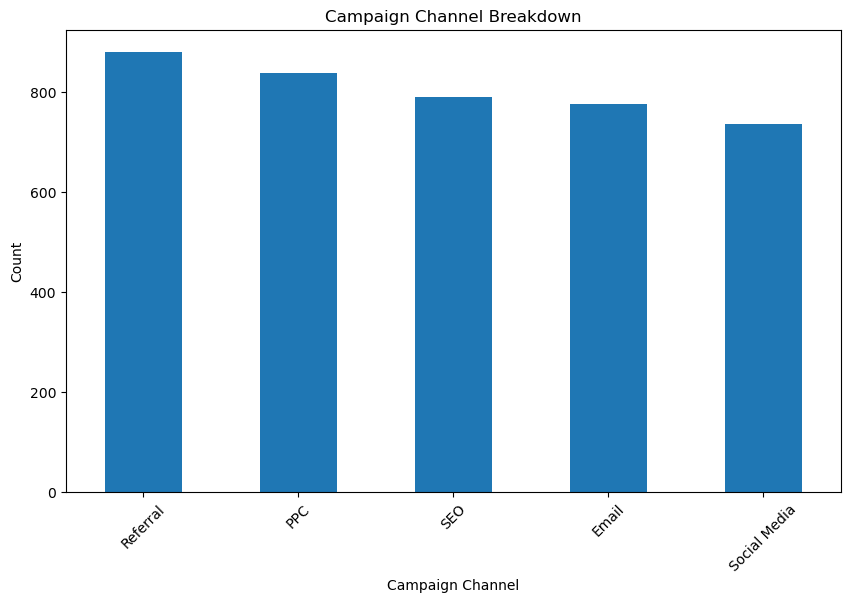

In [50]:
# Assuming df_marketing is defined and has a 'CampaignChannel' column
campaign_counts = df_marketing['CampaignChannel'].value_counts()

# Plotting the bar chart
plt.figure(figsize=(10, 6))
campaign_counts.plot(kind='bar')
plt.title("Campaign Channel Breakdown")
plt.xlabel("Campaign Channel")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()


Label encoding for non-numerical columns

In [51]:
# Initialize label encoders
gender_encoder = LabelEncoder()
campaign_type_encoder = LabelEncoder()


# Dropping the CustomerID
df_marketing = df_marketing.drop(columns=['CustomerID'])


# Apply label encoding 
df_marketing.loc[:,'Gender'] = gender_encoder.fit_transform(df_marketing['Gender'])
df_marketing.loc[:,'CampaignType'] = campaign_type_encoder.fit_transform(df_marketing['CampaignType'])


df_marketing

,Age,Gender,Income,CampaignChannel,CampaignType,AdSpend,ConversionRate,EmailClicks,PreviousPurchases,LoyaltyPoints,Conversion,Revenue,ROI,CLV
1,69,1,41760,Email,1,3898.668606,0.182725,7,2,3459,1,10963.48098,1.812109,126918
3,32,0,44085,PPC,0,539.525936,0.088004,2,0,2463,1,5280.25122,8.786835,0
4,60,0,83964,PPC,0,1678.043573,0.109940,6,8,4345,1,6596.40618,2.931010,514760
7,56,0,57083,Social Media,0,5324.283667,0.188946,3,0,2983,1,11336.75550,1.129255,0
8,36,0,140788,Email,1,9421.250951,0.112585,8,5,460,1,6755.10066,-0.282993,302300
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7989,50,0,84079,PPC,1,277.975579,0.183031,0,0,2935,0,10981.84434,38.506508,0
7991,62,0,69289,SEO,1,6118.863881,0.047079,5,3,3075,1,2824.75710,-0.538353,189225
7992,37,1,138422,Referral,1,2024.148848,0.068403,0,5,2733,0,4104.17598,1.027606,313665
7993,20,1,120271,Social Media,1,6973.120174,0.174582,1,7,3066,0,10474.92798,0.502187,441462


Feature selection using random forest regressor

Reduce dimensions, overfitting rsik and also avoid more multicollinearity issues across the different features

In [52]:
X = df_marketing.drop(columns=['ROI', 'CampaignChannel'])  # Features
y = df_marketing['ROI']  # Target variable

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the Random Forest model
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Calculate and sort feature importances
feature_importances = pd.Series(rf.feature_importances_, index=X_train.columns)
feature_importances_sorted = feature_importances.sort_values(ascending=False)

print("Feature importances (sorted):")
print(feature_importances_sorted)

# Ensure the 'Models' directory exists
if not os.path.exists('Models'):
    os.makedirs('Models')

# Save the model as a pickle file
with open('Models/random_forest_model_overall.pkl', 'wb') as f:
    pickle.dump(rf, f)


Feature importances (sorted):
AdSpend              0.741362
Revenue              0.127274
ConversionRate       0.110763
Income               0.008516
LoyaltyPoints        0.002780
Age                  0.002495
CLV                  0.002034
PreviousPurchases    0.001966
EmailClicks          0.001271
Conversion           0.000772
Gender               0.000462
CampaignType         0.000306
dtype: float64


Campaign cost in this case is the greatest contributor to how effective our campaign is, followed by the revenue and conversionr rate.

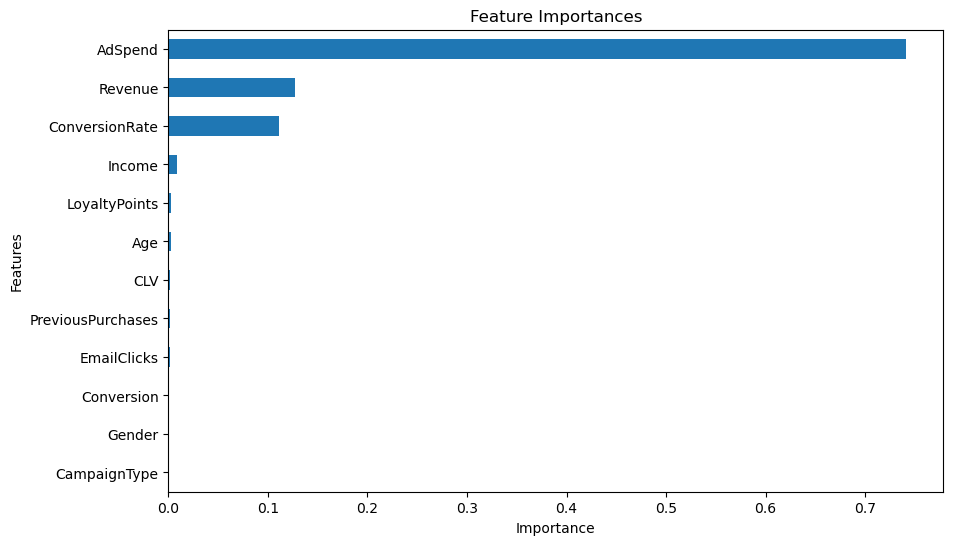

In [53]:
plt.figure(figsize=(10, 6))
feature_importances.sort_values(ascending=True).plot(kind='barh')
plt.title("Feature Importances")
plt.xlabel("Importance")
plt.ylabel("Features")
plt.show()

Post Feature selection, we will begin training the model for each of our 5 marketing strategies to predict the ROI and performance.

Training a few model according to the cleaned data and using a threshold of 0.8 for model training

## Linear Regression

Starting off with simpler models

In [54]:
# Ensure the 'Models' directory exists
if not os.path.exists('Models'):
    os.makedirs('Models')

# Get the top 7 features so that we have CLV Inclusive
top_features = feature_importances.nlargest(7).index

marketing_strategies = df_marketing['CampaignChannel'].unique().tolist()

# Conduct analysis for each marketing strategy
for strategy in marketing_strategies:
    print(f"========== {strategy} ==========")

    # Filter dataset for the current strategy
    X_strategy = df_marketing[df_marketing['CampaignChannel'] == strategy]
    Y_strategy = X_strategy['ROI']
    X_strategy = X_strategy.drop(columns=['ROI', 'CampaignChannel'])
    X_strategy = X_strategy[top_features]

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X_strategy, Y_strategy, test_size=0.2, random_state=42)

    # Train the model
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Calculate performance metrics
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    # Display results
    print(f"Mean Absolute Error (MAE): {mae}")
    print(f"Root Mean Squared Error (RMSE): {rmse}")
    print(f"R2 Score: {r2}")
    print(f'ROI Mean: {Y_strategy.mean()}')
    print()

    # Save the model
    model_filename = f"Models/linear_regression_model_{strategy}.pkl"
    with open(model_filename, 'wb') as file:
        pickle.dump(model, file)


========== Email ==========
Mean Absolute Error (MAE): 1.9251074787062414
Root Mean Squared Error (RMSE): 3.746296124529667
R2 Score: 0.3434977186033117
ROI Mean: 1.4581831090204065

========== PPC ==========
Mean Absolute Error (MAE): 2.23897003707027
Root Mean Squared Error (RMSE): 3.044893197613124
R2 Score: 0.32562338597022045
ROI Mean: 1.8895801537151282

========== Social Media ==========
Mean Absolute Error (MAE): 2.843349904873616
Root Mean Squared Error (RMSE): 4.909859329905014
R2 Score: 0.27380509728666835
ROI Mean: 2.1971547087470658

========== Referral ==========
Mean Absolute Error (MAE): 2.5325268410516353
Root Mean Squared Error (RMSE): 5.603152694203044
R2 Score: 0.2836530701122941
ROI Mean: 1.8996245008144463

========== SEO ==========
Mean Absolute Error (MAE): 2.5891701625823655
Root Mean Squared Error (RMSE): 4.682717672043169
R2 Score: 0.36805139997725345
ROI Mean: 1.9732796784077806



## Randomforest Regressor

In [55]:
# Randomized Search CV to get the best given parameters that will return the best results
def rf_best_params(X_train, y_train):
    param_dist = {
        'n_estimators': [50, 100, 200],
        'max_depth': [5, 10, 15],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }

    random_search = RandomizedSearchCV(RandomForestRegressor(random_state=42), param_distributions=param_dist, n_iter=20, cv=5, scoring='neg_mean_squared_error', random_state=42)
    random_search.fit(X_train, y_train)

    best_params = random_search.best_params_
    return best_params


In [56]:
# Ensure the 'Models' directory exists
if not os.path.exists('Models'):
    os.makedirs('Models')

# Get the unique strategies
marketing_strategies = df_marketing['CampaignChannel'].unique().tolist()

# Conduct analysis for each strategy
for strategy in marketing_strategies:
    print(f"========== {strategy} ==========")

    # Filter dataset for the current strategy
    X_strategy = df_marketing[df_marketing['CampaignChannel'] == strategy]
    Y_strategy = X_strategy['ROI']
    X_strategy = X_strategy.drop(columns=['ROI', 'CampaignChannel'])
    X_strategy = X_strategy[top_features]

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X_strategy, Y_strategy, test_size=0.2, random_state=42)

    # Get the best parameters for RandomForestRegressor
    best_params = rf_best_params(X_train, y_train)

    # Train the model
    model = RandomForestRegressor(**best_params, random_state=42)
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Calculate performance metrics
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    # Display results
    print(f"Mean Absolute Error (MAE): {mae}")
    print(f"Root Mean Squared Error (RMSE): {rmse}")
    print(f"R2 Score: {r2}")
    print(f'ROI Mean: {Y_strategy.mean()}')
    print()

    # Save the model
    model_filename = f"Models/random_forest_model_{strategy}.pkl"
    with open(model_filename, 'wb') as file:
        pickle.dump(model, file)
    


========== Email ==========
Mean Absolute Error (MAE): 0.3635846723121918
Root Mean Squared Error (RMSE): 1.4621629173026365
R2 Score: 0.8999945739883014
ROI Mean: 1.4581831090204065

========== PPC ==========
Mean Absolute Error (MAE): 0.13090542932784355
Root Mean Squared Error (RMSE): 0.3614253063283053
R2 Score: 0.990498427443445
ROI Mean: 1.8895801537151282

========== Social Media ==========
Mean Absolute Error (MAE): 0.517514965653648
Root Mean Squared Error (RMSE): 2.1296559773232175
R2 Score: 0.8633737953258844
ROI Mean: 2.1971547087470658

========== Referral ==========
Mean Absolute Error (MAE): 0.7038192118197603
Root Mean Squared Error (RMSE): 3.1500072996704787
R2 Score: 0.7735972963734217
ROI Mean: 1.8996245008144463

========== SEO ==========
Mean Absolute Error (MAE): 0.8148669522459936
Root Mean Squared Error (RMSE): 3.3971226004689283
R2 Score: 0.6674107186663398
ROI Mean: 1.9732796784077806



## Gradient Boosting Regressor

By comparing different model,  gradient boosting regressor seems the most effective and we will use it as our main model for predicting the ROI

In [57]:
# Ensure the 'Models' directory exists
if not os.path.exists('Models'):
    os.makedirs('Models')

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.1, 0.2, 0.3],
    'max_depth': [3, 4, 5]
}

# Get the unique strategies
marketing_strategies = df_marketing['CampaignChannel'].unique().tolist()

# Conduct analysis for each strategy
for strategy in marketing_strategies:
    print(f"========== {strategy} ==========")

    # Filter dataset for the current strategy
    X_strategy = df_marketing[df_marketing['CampaignChannel'] == strategy]
    Y_strategy = X_strategy['ROI']
    X_strategy = X_strategy.drop(columns=['ROI', 'CampaignChannel'])
    X_strategy = X_strategy[top_features]

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X_strategy, Y_strategy, test_size=0.2, random_state=42)

    # Initialize the model
    model = GradientBoostingRegressor(random_state=42)

    # Perform GridSearchCV for hyperparameter tuning
    grid_search = RandomizedSearchCV(estimator=model, param_distributions=param_grid, scoring='neg_mean_squared_error', cv=3, n_jobs=-1)
    grid_search.fit(X_train, y_train)

    # Get the best parameters
    best_params = grid_search.best_params_
    

    # Train the model with the best parameters
    model = GradientBoostingRegressor(**best_params, random_state=42)
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Calculate performance metrics
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    # Display results
    print(f"Mean Absolute Error (MAE): {mae}")
    print(f"Root Mean Squared Error (RMSE): {rmse}")
    print(f"R2 Score: {r2}")
    print(f'ROI Mean: {Y_strategy.mean()}')
    print()

    # Save the model
    model_filename = f"Models/gradient_boosting_model_{strategy}.pkl"
    with open(model_filename, 'wb') as file:
        pickle.dump(model, file)
    


========== Email ==========
Mean Absolute Error (MAE): 0.31036795282328883
Root Mean Squared Error (RMSE): 1.4629699982375177
R2 Score: 0.8998841420419087
ROI Mean: 1.4581831090204065

========== PPC ==========
Mean Absolute Error (MAE): 0.1691073072584049
Root Mean Squared Error (RMSE): 0.38569913825855895
R2 Score: 0.9891792911777924
ROI Mean: 1.8895801537151282

========== Social Media ==========
Mean Absolute Error (MAE): 0.8126874634872142
Root Mean Squared Error (RMSE): 3.7062697413700953
R2 Score: 0.5862012779478349
ROI Mean: 2.1971547087470658

========== Referral ==========
Mean Absolute Error (MAE): 0.4339494103814285
Root Mean Squared Error (RMSE): 1.7942716967387915
R2 Score: 0.9265427101426366
ROI Mean: 1.8996245008144463

========== SEO ==========
Mean Absolute Error (MAE): 0.48677589405591165
Root Mean Squared Error (RMSE): 1.8028602725731953
R2 Score: 0.9063279671968358
ROI Mean: 1.9732796784077806

